In [172]:
from __future__ import annotations

import pandas as pd
import numpy as np
import sys
import traceback
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn
import dataclasses
import os



import pickle

import dill

In [173]:
dataset: Literal["ihdp","jobs"] = "jobs"

In [174]:
import warnings
warnings.filterwarnings("ignore")

#print(sns.plotting_context())

sns.set_theme(style="darkgrid",context="paper")

import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

In [175]:
from assignment2.a2_utils.seed_utils import *

from assignment2.a2_utils.misc_utils import *

import assignment2.a2_utils.seed_utils as seed_utils
import assignment2.a2_utils.misc_utils as misc_utils
import assignment2.a2_utils.metric_utils as metric_utils
import assignment2.a2_utils.dataframe_utils as df_utils
import assignment2.a2_utils.simple_learner_utils as slearner

import econml


""

''

# JOBS dataset processing


In [176]:

jobs_full: pd.DataFrame = df_utils.turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full JOBS dataset as a dataframe"

jobs_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,t,y,e,tcf
0,-0.614282,1.464727,0,0,1,0,2.393250,2.746196,-0.653311,-0.656913,...,2.462337,2.937244,0,0,2.843909,0,0,1,0,1
1,-0.802463,0.101835,0,0,1,0,0.109885,0.498271,-0.785284,-0.743407,...,-0.177193,0.082537,0,0,0.038422,0,0,1,0,1
2,-0.896553,-0.238888,1,0,1,1,-0.085212,-0.148097,-0.847312,-0.781606,...,-0.286221,-0.303615,0,0,-0.191304,0,0,1,0,1
3,-0.896553,-0.238888,0,0,0,1,0.405581,0.325594,-0.847312,-0.781606,...,0.023020,-0.039630,0,0,0.173108,0,0,1,1,1
4,0.138440,-1.601779,1,0,1,1,-0.722531,-0.212734,-0.019840,-0.156019,...,-0.514563,-0.331552,0,0,-0.779227,0,0,1,0,1


In [177]:
jobs_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      3212 non-null   float64
 1   x1      3212 non-null   float64
 2   x2      3212 non-null   uint8  
 3   x3      3212 non-null   uint8  
 4   x4      3212 non-null   uint8  
 5   x5      3212 non-null   uint8  
 6   x6      3212 non-null   float64
 7   x7      3212 non-null   float64
 8   x8      3212 non-null   float64
 9   x9      3212 non-null   float64
 10  x10     3212 non-null   float64
 11  x11     3212 non-null   float64
 12  x12     3212 non-null   float64
 13  x13     3212 non-null   uint8  
 14  x14     3212 non-null   uint8  
 15  x15     3212 non-null   float64
 16  x16     3212 non-null   uint8  
 17  t       3212 non-null   uint8  
 18  y       3212 non-null   uint8  
 19  e       3212 non-null   uint8  
 20  tcf     3212 non-null   uint8  
dtypes: float64(10), uint8(11)
memory usag

In [178]:
dfm: df_utils.DataframeManager = df_utils.DataframeManager.make(
    dataset_name = dataset,
    the_df = jobs_full,
    test_proportion = 0.1,
    split_randomstate = rng_state(),
    columns_for_training_stratification= ["t","e","y"],
    t_column = "t",
    t_cf_column = "tcf",
    y_column = "y",
    e_column = "e",

)


In [179]:
dfm.save_self()

pickling self as \jobs\jobs DataframeManager.pickle...
pickled!


True

In [180]:
from sklearn.model_selection import KFold
from sklearn.model_selection._validation import NotFittedError
from sklearn.base import ClassifierMixin, TransformerMixin
from sklearn.linear_model import ARDRegression, SGDClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.metrics import r2_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.utils import Bunch
from math import inf

set_config(display="diagram")



# Part 3 - Simple Learners

In [181]:
%%time

rf_min_samples = [2,4,6,8]
rf_min_impurity_decrease =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_max_features = [None,"sqrt","log2",1,2]
rf_ccp_alpha =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_n_estimators = [50,100,150,200]

rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features":rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)


-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 500
n_resources: 7
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
----------
iter: 1
n_candidates: 63
n_resources: 7
Fitting 10 folds for each of 63 candidates, totalling 630 fits
----------
iter: 2
n_candidates: 8
n_resources: 7
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary Random Forest simple jobs
	test score:	0.05141334081503812
	train score:0.08019262782375895
	y score:	0.11880291216390815
	abs ATT:	2.6041513170924935
	p. risk:	0.008949499254208404

--- 1/4 END ---
-- 10-fold attempt 2/4 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 100
aggressive_elimination: True
factor: 10


In [182]:

rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_searched
)


In [183]:

print(rf_simple_best.info)



rf_simple_best.best_estimator_


GridSearchResults summary Random Forest simple jobs
	test score:	0.05141334081503812
	train score:0.069318011202359
	y score:	0.11880291216390815
	abs ATT:	0.009205783323430375
	p. risk:	0.0
	best params:
		estimator__ccp_alpha : 0.00011066819197003216
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.0012247448713915891
		estimator__min_samples_split : 2
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.00011066819197003216,
                                         max_features=None,
                                         min_impurity_decrease=0.0012247448713915891,
                                         random_state=42))])

In [184]:
rf_simple_best.save_me()

Pickling results to: \jobs\jobs Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Random Forest simple feature importances.pdf


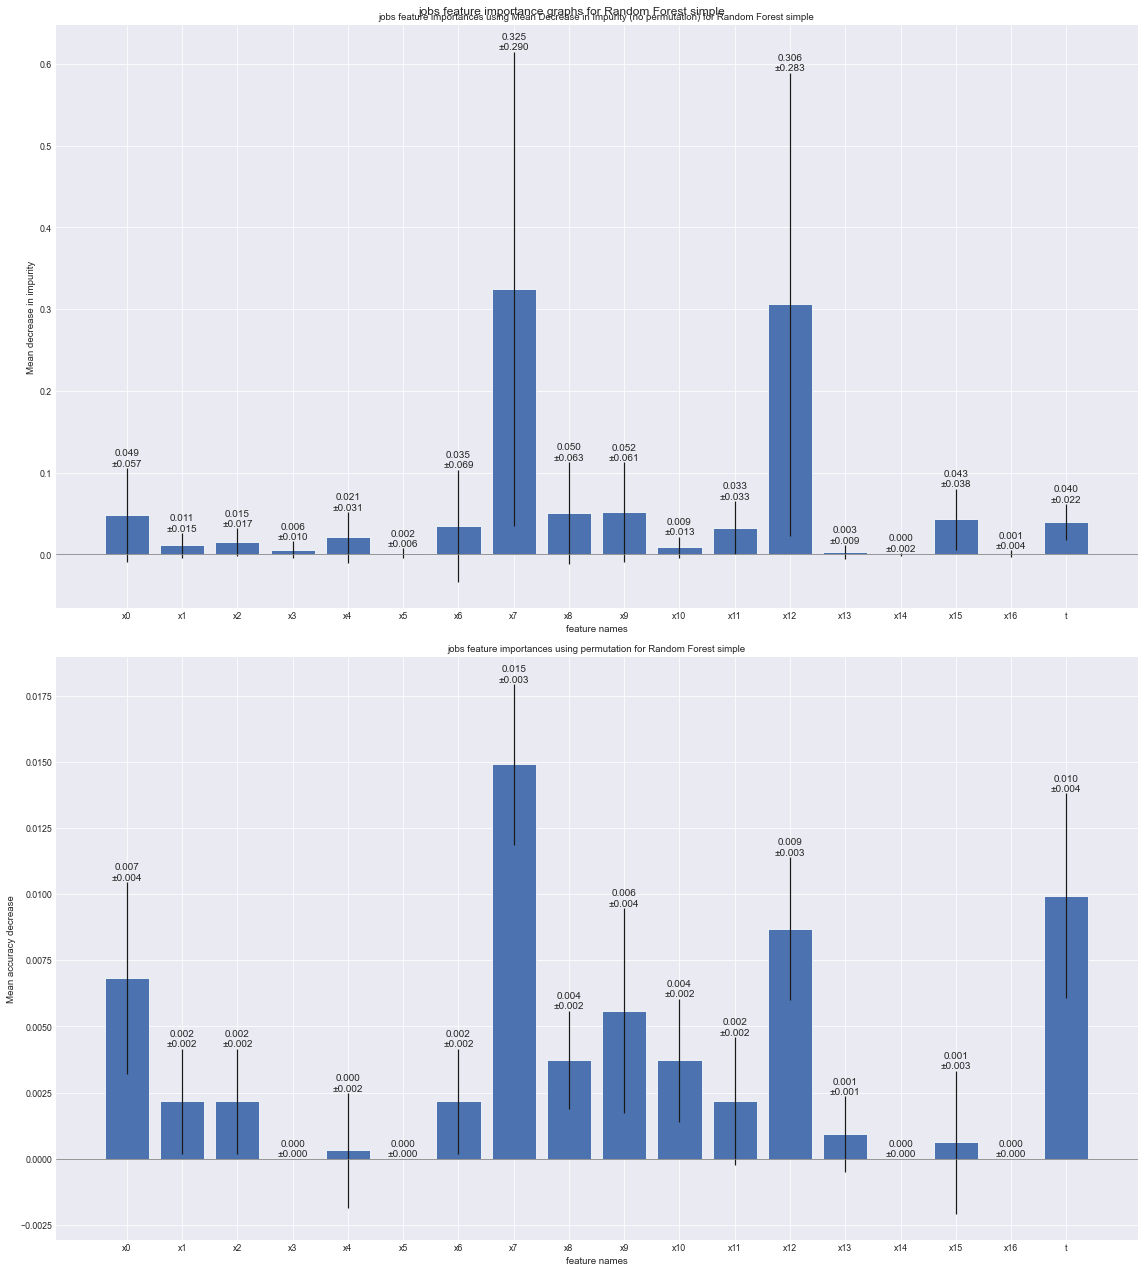

In [185]:
rf_simple_best.importance_plotter().show()

In [ ]:
%%time

ard_iter: List[int] = [200, 250, 300]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1" : ard_alpha_lambda,
        "estimator__alpha_2" : ard_alpha_lambda,
        "estimator__lambda_1" : ard_alpha_lambda,
        "estimator__lambda_2" : ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_iter",
    resource_param_values=ard_iter
)

-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 250, min: 16, factor: 16
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 16
max_resources_: 250
aggressive_elimination: True
factor: 16
-

In [ ]:

ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_searched
)




In [ ]:

print(ard_simple_best.info)


ard_simple_best.best_estimator_


In [ ]:
ard_simple_best.save_me()

In [ ]:
ard_simple_best.importance_plotter().show()

In [ ]:
%%time

sgd_max_iter: List[int] = [500,1000,1500]
sgd_alpha: List[float] = [0.001, 0.0001, 0.00001]
sgd_learning_rate: List[str] =  ["constant","optimal","invscaling","adaptive"]
sgd_power_t: List[float] = [0.25,0.5,0.75]
sgd_l1_ratio: List[float] = [0, 0.15, 0.5, 0.85, 1]

sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)

In [ ]:

sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_searched
)



In [ ]:

print(sgd_simple_best.info)

sgd_simple_best.best_estimator_


In [ ]:
sgd_simple_best.save_me()

In [ ]:
sgd_simple_best.importance_plotter().show()

In [ ]:
%%time

adaboost_estimators: List[int] = [25, 50, 75]
adaboost_learn_rate: List[float] = [0.8, 0.9, 1.0, 1.1, 1.2]

ada_rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_searched
)



In [ ]:

print(ada_rf_simple_best.info)



ada_rf_simple_best.best_estimator_


In [ ]:
ada_rf_simple_best.save_me()

In [ ]:
ada_rf_simple_best.importance_plotter().show()

In [ ]:
%%time

ada_ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            est for est in
            misc_utils.chain_1(
                [pl.clone_best_final_estimator for pl in ard_simple_searched],
                ARDRegression()
            )
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)



In [ ]:

ada_ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_searched
)




In [ ]:


print(ada_ard_simple_best.info)


ada_ard_simple_best.best_estimator_


In [ ]:
ada_ard_simple_best.save_me()

In [ ]:
ada_ard_simple_best.importance_plotter().show()

In [ ]:
%%time

ada_sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost SGD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)


In [ ]:
ada_sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_simple_searched
)

In [ ]:

print(ada_sgd_simple_best.info)

ada_sgd_simple_best.best_estimator_


In [ ]:
ada_sgd_simple_best.save_me()

In [ ]:
ada_sgd_simple_best.importance_plotter().show()

In [ ]:


all_simple_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_best,
    ard_simple_best,
    sgd_simple_best,
    ada_rf_simple_best,
    ada_ard_simple_best,
    ada_sgd_simple_best
]

all_simple_best.sort(reverse=True)


In [ ]:
for bc in all_simple_best:
    print(bc.summary_info)

print("")

In [ ]:
best_simple_est: slearner.PPipeline = max(all_simple_best).best_estimator_

# Part 4 - Inverse Propensity Weights


### attempting to find the likelihood of individuals being NOT being included in the treatment group

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time

rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": rf_ccp_alpha,
        "estimator__class_weight": ["balanced", "balanced subsample"],
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
)

In [ ]:

rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_ipsw_searched
)



In [ ]:
print(rf_ipsw_best.info)

rf_ipsw_best.best_estimator_

In [ ]:
rf_ipsw_best.save_me()

In [ ]:
rf_ipsw_best.importance_plotter().show()

In [ ]:
%%time

# note: ridge does not support predict_proba, unusable, replaced with SGDClassifier.

sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        loss="log",
        penalty="elasticnet"
    ),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio,
        "estimator__class_weight": ["balanced", None]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="sgd IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)


In [ ]:
sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_ipsw_searched
)

In [ ]:

print(sgd_ipsw_best.info)

sgd_ipsw_best.best_estimator_

In [ ]:

sgd_ipsw_best.save_me()

In [ ]:

sgd_ipsw_best.importance_plotter().show()

In [ ]:
%%time

ada_rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:
ada_rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_ipsw_searched
)

In [ ]:

print(ada_rf_ipsw_best.info)

ada_rf_ipsw_best.best_estimator_

In [ ]:

ada_rf_ipsw_best.save_me()

In [ ]:

ada_rf_ipsw_best.importance_plotter().show()

In [ ]:
%%time

ada_sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost SGD IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:


ada_sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_ipsw_searched
)

In [ ]:

print(ada_sgd_ipsw_best.info)

ada_sgd_ipsw_best.best_estimator_

In [ ]:

ada_sgd_ipsw_best.save_me()

In [ ]:

ada_sgd_ipsw_best.importance_plotter().show()

In [ ]:
all_ipsw_clf_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_ipsw_best,
    sgd_ipsw_best,
    ada_rf_ipsw_best,
    ada_sgd_ipsw_best
]

all_ipsw_clf_best.sort(reverse=True)

for bc in all_ipsw_clf_best:
    print(bc.summary_info)

print("")

In [ ]:
best_ipsw_predictor: slearner.PPipeline = max(all_ipsw_clf_best).best_estimator_

ipsw_calc: slearner.IpswWrapper = slearner.IpswWrapper.make(
    best_ipsw_predictor,
    dataset_name=dataset
)

ipsw_calc.save_me()


### And now using these weights to redo the earlier simple estimators

In [ ]:
%%time


rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

In [ ]:

rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_ipsw_searched
)

In [ ]:

print(rf_simple_ipsw_best.info)

rf_simple_ipsw_best.best_estimator_

In [ ]:

rf_simple_ipsw_best.save_me()

In [ ]:
rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1": ard_alpha_lambda,
        "estimator__alpha_2": ard_alpha_lambda,
        "estimator__lambda_1": ard_alpha_lambda,
        "estimator__lambda_2": ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_iter",
    sample_weights=ipsw_calc,
    resource_param_values=ard_iter
)


In [ ]:
ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_ipsw_searched
)


In [ ]:
print(ard_simple_ipsw_best.info)

ard_simple_ipsw_best.best_estimator_


In [ ]:
ard_simple_ipsw_best.save_me()

In [ ]:
ard_simple_best.importance_plotter().show()

In [ ]:
%%time

sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter,
    sample_weights=ipsw_calc
)

In [ ]:

sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_ipsw_searched
)

In [ ]:

print(sgd_simple_ipsw_best.info)

sgd_simple_ipsw_best.best_estimator_

In [ ]:

sgd_simple_ipsw_best.save_me()

In [ ]:
sgd_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ada_rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    sample_weights=ipsw_calc,
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_ipsw_searched
)

In [ ]:

print(ada_rf_simple_ipsw_best.info)

ada_rf_simple_ipsw_best.best_estimator_


In [ ]:
ada_rf_simple_ipsw_best.save_me()

In [ ]:
ada_rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time
ada_ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in ard_simple_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=adaboost_estimators,
)


In [ ]:
ada_ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_ipsw_searched
)


In [ ]:
print(ada_ard_simple_ipsw_best.info)

ada_ard_simple_ipsw_best.best_estimator_


In [ ]:
ada_ard_simple_ipsw_best.save_me()

In [ ]:
ada_ard_simple_ipsw_best.importance_plotter().show()


In [ ]:
%%time


ada_sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_simple_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost SGD simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_simple_ipsw_searched
)

In [ ]:

print(ada_sgd_simple_ipsw_best.info)

ada_sgd_simple_ipsw_best.best_estimator_

In [ ]:

ada_sgd_simple_ipsw_best.save_me()

In [ ]:
ada_sgd_simple_ipsw_best.importance_plotter().show()

In [ ]:
all_simple_ipsw_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_ipsw_best,
    ard_simple_ipsw_best,
    sgd_simple_ipsw_best,
    ada_rf_simple_ipsw_best,
    ada_ard_simple_ipsw_best,
    ada_sgd_simple_ipsw_best
]

all_simple_ipsw_best.sort(reverse=True)

In [ ]:

for bc in all_simple_ipsw_best:
    print(bc.summary_info)

print("")

In [ ]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")

# 5: The CATE stuff

In [ ]:
from econml.dml import CausalForestDML


import shap

In [ ]:
# obtaining train/test data for the CATE stuff.

X, Y = dfm.x_y(train=True, x_columns=df_utils.DatasetEnum.X_Y)

_, T = dfm.x_y(train=True, x_columns=df_utils.DatasetEnum.X_T)

x_test, y_test = dfm.x_y(train=False, x_columns=df_utils.DatasetEnum.X_Y)

_, t_test = dfm.x_y(train=False, x_columns=df_utils.DatasetEnum.X_T)


In [ ]:
%%time

causal_forest: CausalForestDML = CausalForestDML(
    criterion='het',
    n_estimators=10000,
    min_samples_leaf=10,
    max_depth=None,
    max_samples=0.5,
    discrete_treatment=True,
    honest=True,
    inference=True,
    cv=10,
    random_state=seed(),
    model_t=sklearn.base.clone(best_ipsw_predictor),
    model_y=sklearn.base.clone(best_simple_est),
    verbose=1
)

# fit train data to causal forest model
causal_forest.fit(Y, T, X=X, W=None)
# estimate the CATE with the test set
causal_forest.const_marginal_ate(x_test)

In [ ]:
slearner.standalone_feature_importance_plotter(
    predictor=causal_forest,
    x_data=x_test,
    y_data=y_test,
    predictor_name="Causal Forest",
    dataset_name=dataset
)

In [ ]:
%%time


# fit causal forest with default parameters
#shap_causal_forest = CausalForestDML()
#shap_causal_forest.fit(Y, T, X=X, W=None)

# calculate shap values of causal forest model
shap_values = causal_forest.shap_values(X)
# plot shap values
shap.summary_plot(shap_values['Y0']['T0'])

In [ ]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")